Bu projede amaç yapılan yorumlardan yola çıkarak bir film sitesindeki filmlere yapılan yorumları pozitif, negatif, nötr olarak puanlarına göre sınıflandıran bir yapay zeka algoritması geliştirmektir. Bunu yaparken literatürde çok sık kullanılan makine öğrenimi ve derin öğrenme algoritmaları araştırılarak denenmiş ve sonuçlar sütun grafiğinde gösterilmiştir.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout
from gensim.models import Word2Vec
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

lemma = WordNetLemmatizer()
import json
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
data_movies = pd.read_csv('/content/drive/MyDrive/archive/movies_metadata.csv')
print(data_movies.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

<ipython-input-3-500345a3b6b9>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_movies = pd.read_csv('/content/drive/MyDrive/archive/movies_metadata.csv')


In [4]:
comments = data_movies[["overview"]]
print(comments)

                                                overview
0      Led by Woody, Andy's toys live happily in his ...
1      When siblings Judy and Peter discover an encha...
2      A family wedding reignites the ancient feud be...
3      Cheated on, mistreated and stepped on, the wom...
4      Just when George Banks has recovered from his ...
...                                                  ...
45461        Rising and falling between a man and woman.
45462  An artist struggles to finish his work while a...
45463  When one of her hits goes wrong, a professiona...
45464  In a small town live two brothers, one a minis...
45465  50 years after decriminalisation of homosexual...

[45466 rows x 1 columns]


In [5]:
# 'overview' sütununu alalım ve sadece harf karakterlerini koruyalım
comments = data_movies[["overview"]]
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
comments_str = comments['overview'].astype(str)
reg_comments = comments_str.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))


In [6]:
# TF-IDF Vektörizasyonu
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
tfidf_matrix = tfidf_vectorizer.fit_transform(reg_comments.tolist())
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


In [7]:
# Duygu analizi yapmak için bir işlev tanımlayalım
def analyze_sentiment(text):
    analysis = TextBlob(text)
    sentiment = analysis.sentiment.polarity
    words = text.split()
    filtered_words = [lemma.lemmatize(word).lower() for word in words if word.lower() not in stop_words]
    cleaned_text = ' '.join(filtered_words)

    return {
        'yorum': text,
        'temizlenmis_yorum': cleaned_text,
        'duygu': 'pozitif' if sentiment > 0 else 'negatif' if sentiment < 0 else 'nötr'
    }


In [8]:
# 'overview' sütununu dizeye çevirelim ve bir liste olarak saklayalım
reg_comments_list = reg_comments.astype(str).tolist()

# Duygu analizi ve TF-IDF vektörizasyonunu uygulayalım
results = [analyze_sentiment(comment) for comment in reg_comments_list]
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
tfidf_matrix = tfidf_vectorizer.fit_transform(reg_comments_list)
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Sonuçları düzgün sütunlar halinde göstermek için yeni bir DataFrame oluşturalım
result_df = pd.DataFrame({
    'Yorum': reg_comments,
    'Temizlenmiş Yorum': [result['temizlenmis_yorum'] for result in results],
    'Duygu': [result['duygu'] for result in results]
})

print(result_df)

                                                   Yorum  \
0      Led by Woody  Andy s toys live happily in his ...   
1      When siblings Judy and Peter discover an encha...   
2      A family wedding reignites the ancient feud be...   
3      Cheated on  mistreated and stepped on  the wom...   
4      Just when George Banks has recovered from his ...   
...                                                  ...   
45461        Rising and falling between a man and woman    
45462  An artist struggles to finish his work while a...   
45463  When one of her hits goes wrong  a professiona...   
45464  In a small town live two brothers  one a minis...   
45465     years after decriminalisation of homosexual...   

                                       Temizlenmiş Yorum    Duygu  
0      led woody andy toy live happily room andy birt...  pozitif  
1      sibling judy peter discover enchanted board ga...  negatif  
2      family wedding reignites ancient feud next doo...  pozitif  
3      

In [9]:
# Özellikleri ve hedef değişkenini seçelim
X = tfidf_df
y = result_df['Duygu']

# Verileri eğitim ve test setlerine bölelim
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1500, random_state=42)

# LabelEncoder kullanarak duygu etiketlerini sayısal hale getirelim
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Naive Bayes Sınıflandırıcı
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_y_pred = nb_classifier.predict(X_test)

# Random Forest Sınıflandırıcı
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_y_pred = rf_classifier.predict(X_test)

print("Naive Bayes Sınıflandırıcı Sonuçları:")
print(classification_report(y_test, nb_y_pred))

print("Random Forest Sınıflandırıcı Sonuçları:")
print(classification_report(y_test, rf_y_pred))

Naive Bayes Sınıflandırıcı Sonuçları:
              precision    recall  f1-score   support

     negatif       0.81      0.37      0.51       462
        nötr       1.00      0.18      0.30       213
     pozitif       0.64      0.97      0.77       825

    accuracy                           0.67      1500
   macro avg       0.82      0.51      0.53      1500
weighted avg       0.74      0.67      0.62      1500

Random Forest Sınıflandırıcı Sonuçları:
              precision    recall  f1-score   support

     negatif       0.75      0.43      0.54       462
        nötr       0.74      0.52      0.61       213
     pozitif       0.69      0.91      0.79       825

    accuracy                           0.71      1500
   macro avg       0.73      0.62      0.65      1500
weighted avg       0.72      0.71      0.69      1500



In [10]:
# LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(result_df['Temizlenmiş Yorum'])
X_lstm = tokenizer.texts_to_sequences(result_df['Temizlenmiş Yorum'])
X_lstm = pad_sequences(X_lstm, maxlen=200)
y_lstm = pd.get_dummies(result_df['Duygu']).values

lstm_model = Sequential()
lstm_model.add(Embedding(5000, 128, input_length=X_lstm.shape[1]))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_lstm, y_lstm, epochs=3, batch_size=64)

X_test_lstm = tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=200)

lstm_y_pred = lstm_model.predict(X_test_lstm)
lstm_y_pred = np.argmax(lstm_y_pred, axis=1)
print("LSTM Sonuçları:")
print(classification_report(y_test_encoded, lstm_y_pred))


Epoch 1/3
711/711 [==============================] - 92s 120ms/step - loss: 0.5303 - accuracy: 0.7756
Epoch 2/3
711/711 [==============================] - 20s 28ms/step - loss: 0.3134 - accuracy: 0.8869
Epoch 3/3
47/47 [==============================] - 1s 4ms/step
LSTM Sonuçları:
              precision    recall  f1-score   support

           0       0.26      0.04      0.07       462
           1       0.14      0.88      0.24       213
           2       0.52      0.07      0.12       825

    accuracy                           0.18      1500
   macro avg       0.31      0.33      0.15      1500
weighted avg       0.39      0.18      0.12      1500



In [11]:
# CNN
cnn_model = Sequential()
cnn_model.add(Embedding(5000, 128, input_length=X_lstm.shape[1]))
cnn_model.add(Conv1D(64, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(LSTM(100))
cnn_model.add(Dense(3, activation='softmax'))
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_lstm, y_lstm, epochs=3, batch_size=64)

X_test_cnn = tokenizer.texts_to_sequences(X_test)
X_test_cnn = pad_sequences(X_test_cnn, maxlen=200)
cnn_y_pred = cnn_model.predict(X_test_cnn)
cnn_y_pred = np.argmax(cnn_y_pred, axis=1)
print("CNN Sınıflandırıcı Sonuçları:")
print(classification_report(y_test_encoded, cnn_y_pred))


Epoch 1/3
711/711 [==============================] - 61s 75ms/step - loss: 0.4924 - accuracy: 0.7926
Epoch 2/3
711/711 [==============================] - 17s 24ms/step - loss: 0.2987 - accuracy: 0.8934
Epoch 3/3
47/47 [==============================] - 1s 6ms/step
CNN Sınıflandırıcı Sonuçları:
              precision    recall  f1-score   support

           0       0.26      0.04      0.07       462
           1       0.14      0.88      0.25       213
           2       0.52      0.07      0.12       825

    accuracy                           0.18      1500
   macro avg       0.31      0.33      0.15      1500
weighted avg       0.39      0.18      0.13      1500



In [12]:
# MLP
mlp_classifier = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=300)
mlp_classifier.fit(X_train, y_train_encoded)
mlp_y_pred_encoded = mlp_classifier.predict(X_test)
mlp_y_pred = label_encoder.inverse_transform(mlp_y_pred_encoded)

print("MLP Sınıflandırıcı Sonuçları:")
print(classification_report(y_test, mlp_y_pred))

MLP Sınıflandırıcı Sonuçları:
              precision    recall  f1-score   support

     negatif       0.67      0.71      0.69       462
        nötr       0.73      0.73      0.73       213
     pozitif       0.84      0.81      0.82       825

    accuracy                           0.77      1500
   macro avg       0.75      0.75      0.75      1500
weighted avg       0.77      0.77      0.77      1500



In [13]:
# Pozitif yorumlar için verileri ayıklayalım
positive_reviews = result_df[result_df['Duygu'] == 'pozitif']

# TF-IDF vektörizasyonu için verileri hazırlayalım
positive_comments = positive_reviews['Temizlenmiş Yorum']
tfidf_matrix_positive = tfidf_vectorizer.transform(positive_comments)
tfidf_df_positive = pd.DataFrame(tfidf_matrix_positive.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# MLP sınıflandırıcı ile pozitif yorumları tahmin edelim
mlp_y_pred_positive_encoded = mlp_classifier.predict(tfidf_df_positive)
mlp_y_pred_positive = label_encoder.inverse_transform(mlp_y_pred_positive_encoded)

# Tahmin edilen pozitif yorumlar için puanları alalım
positive_reviews['Tahmini Duygu'] = mlp_y_pred_positive

# 'Tahmini Duygu' sütunundaki pozitif yorumlar için puanları alalım
positive_reviews_with_scores = positive_reviews[positive_reviews['Tahmini Duygu'] == 'pozitif']

# Puanlara göre filmleri sıralayalım ve ilk 5 filmi görüntüleyelim
top_5_positive_movies = positive_reviews_with_scores.sort_values(by='Tahmini Duygu', ascending=False).head(5)
print("Pozitif Yorumlardan En Yüksek Puan Alan İlk 5 Yorum:")
print(top_5_positive_movies[['Yorum', 'Temizlenmiş Yorum', 'Tahmini Duygu']])


Pozitif Yorumlardan En Yüksek Puan Alan İlk 5 Yorum:
                                                   Yorum  \
0      Led by Woody  Andy s toys live happily in his ...   
30523  After losing his parents in a car accident  Mu...   
30296  Based on a true story   Tot altijd  introduces...   
30292  When someone murders his beloved cat  Clinton ...   
30291  A group of friends reunite after    years to c...   

                                       Temizlenmiş Yorum Tahmini Duygu  
0      led woody andy toy live happily room andy birt...       pozitif  
30523  losing parent car accident mukesh stay aunt ho...       pozitif  
30296  based true story tot altijd introduces u band ...       pozitif  
30292  someone murder beloved cat clinton adult child...       pozitif  
30291  group friend reunite year climb mont ventoux m...       pozitif  


<ipython-input-13-2cf38728f358>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews['Tahmini Duygu'] = mlp_y_pred_positive


In [14]:
#Algoritmalarla metrikleri alalım
algorithm_names = ['Naive Bayes', 'Random Forest', 'LSTM', 'CNN', 'MLP']


accuracy_scores = [accuracy_score(y_test, nb_y_pred),
                   accuracy_score(y_test, rf_y_pred),
                   accuracy_score(y_test_encoded, lstm_y_pred),
                   accuracy_score(y_test_encoded, cnn_y_pred),
                   accuracy_score(y_test, mlp_y_pred)]

precision_scores = [precision_score(y_test, nb_y_pred, average='weighted'),
                    precision_score(y_test, rf_y_pred, average='weighted'),
                    precision_score(y_test_encoded, lstm_y_pred, average='weighted'),
                    precision_score(y_test_encoded, cnn_y_pred, average='weighted'),
                    precision_score(y_test, mlp_y_pred, average='weighted')]

recall_scores = [recall_score(y_test, nb_y_pred, average='weighted'),
                 recall_score(y_test, rf_y_pred, average='weighted'),
                 recall_score(y_test_encoded, lstm_y_pred, average='weighted'),
                 recall_score(y_test_encoded, cnn_y_pred, average='weighted'),
                 recall_score(y_test, mlp_y_pred, average='weighted')]

f1_scores = [f1_score(y_test, nb_y_pred, average='weighted'),
             f1_score(y_test, rf_y_pred, average='weighted'),
             f1_score(y_test_encoded, lstm_y_pred, average='weighted'),
             f1_score(y_test_encoded, cnn_y_pred, average='weighted'),
             f1_score(y_test, mlp_y_pred, average='weighted')]



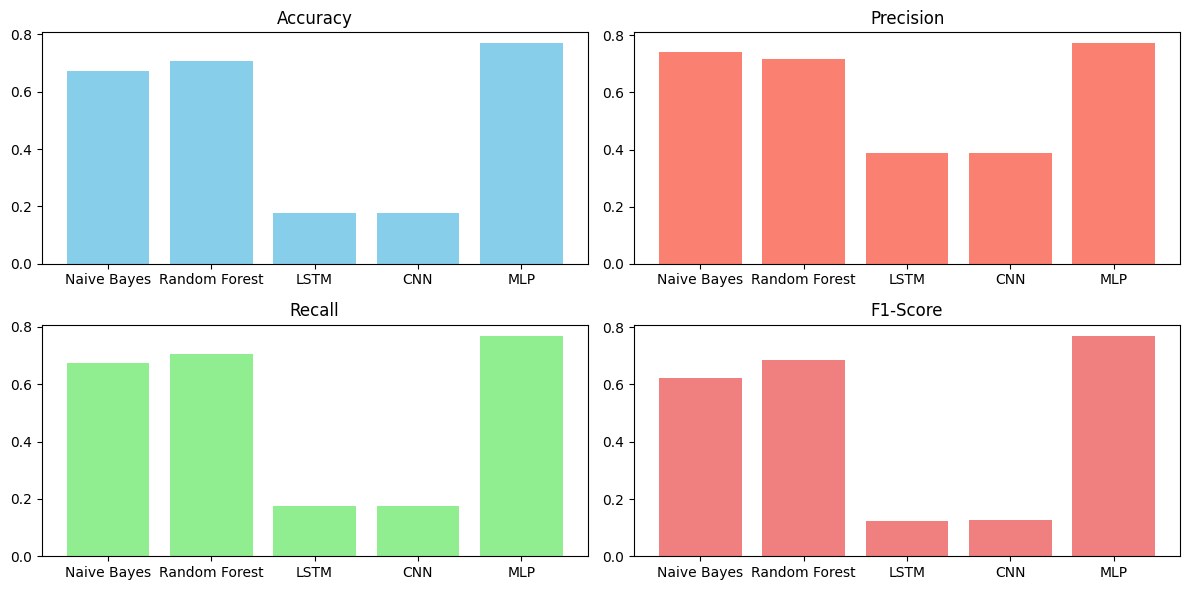

In [15]:
# Metrikleri sütun grafikleri ile gösterelim
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.bar(algorithm_names, accuracy_scores, color='skyblue')
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.bar(algorithm_names, precision_scores, color='salmon')
plt.title('Precision')

plt.subplot(2, 2, 3)
plt.bar(algorithm_names, recall_scores, color='lightgreen')
plt.title('Recall')

plt.subplot(2, 2, 4)
plt.bar(algorithm_names, f1_scores, color='lightcoral')
plt.title('F1-Score')

plt.tight_layout()
plt.show()
